In [1036]:
import sklearn
import sklearn.preprocessing
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import GaussianNoise

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)

### Dataset Cleaning and reformat

In [1037]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')

In [1038]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

In [1039]:
data = data.set_index("timestamp")

In [1040]:
data.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=True)

In [1041]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [1042]:
# Drop NAN value
data = data.dropna()

In [1043]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [1044]:
# Factorize String data
data['cbwd'] = pd.factorize(data['cbwd'])[0]

/Users/rickytechnip/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1045]:
data.to_csv('data/cleaned_data')

### Dataset Visualization

Text(0.5, 1.0, 'PM2.5 with timestamp')

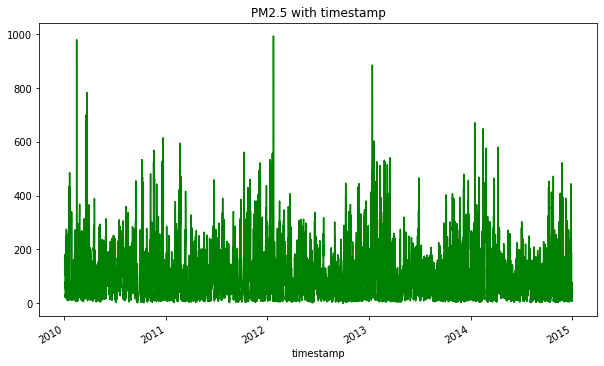

In [1046]:
data['pm2.5'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

Text(0.5, 1.0, 'Cumulated Hours Of Rnow Distribution')

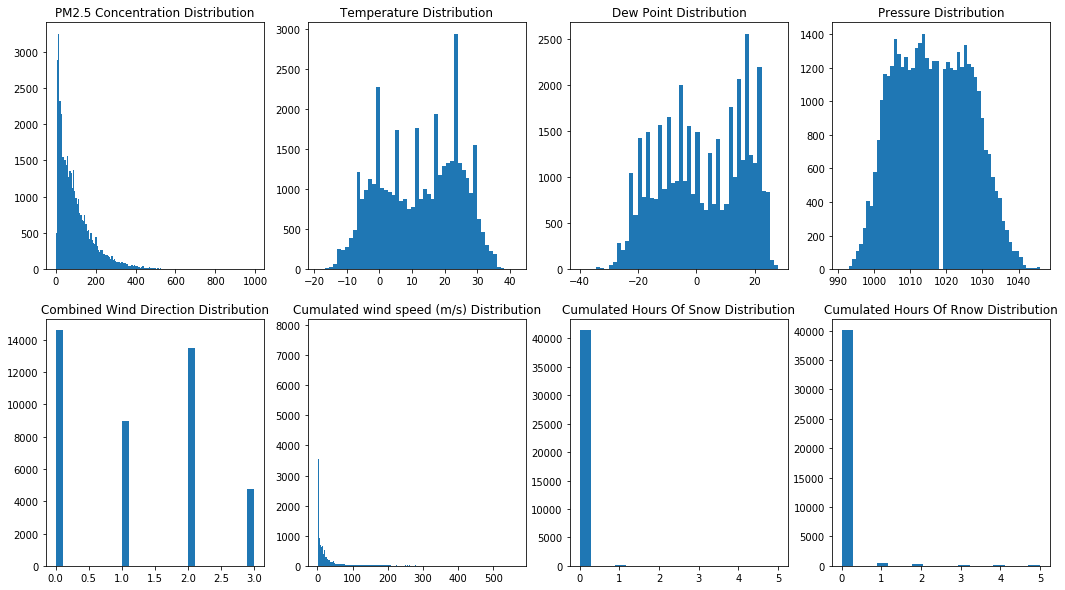

In [1047]:
plt.figure(figsize=(18,10))
plt.subplot(2, 4, 1)
plt.hist(data['pm2.5'], bins='auto')
plt.title('PM2.5 Concentration Distribution')
plt.subplot(2, 4, 2)
plt.hist(data['TEMP'], bins='auto')
plt.title('Temperature Distribution')
plt.subplot(2, 4, 3)
plt.hist(data['DEWP'], bins='auto')
plt.title('Dew Point Distribution')
plt.subplot(2, 4, 4)
plt.hist(data['PRES'], bins='auto')
plt.title('Pressure Distribution')
plt.subplot(2, 4, 5)
plt.hist(data['cbwd'], bins='auto')
plt.title('Combined Wind Direction Distribution')
plt.subplot(2, 4, 6)
plt.hist(data['Iws'], bins='auto')
plt.title('Cumulated wind speed (m/s) Distribution')
plt.subplot(2, 4, 7)
plt.hist(data['Is'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Snow Distribution')
plt.subplot(2, 4, 8)
plt.hist(data['Ir'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Rnow Distribution')

In [1048]:
normalized_data=(data-data.mean())/data.std()

In [1049]:
newdata = normalized_data

In [1050]:
newdata = newdata.assign(anom=pd.Series(np.zeros(len(newdata), dtype=np.int)).values)

In [1051]:
df25 = newdata.iloc[:, 0]

In [1052]:
df25_column = df25 - df25.rolling(5).mean()/df25.rolling(5).mean()
df25_column.iloc

In [1053]:
newdata.loc[df25_column > 3, 'anom'] = 1

Text(0.5, 1.0, 'PM2.5 with timestamp')

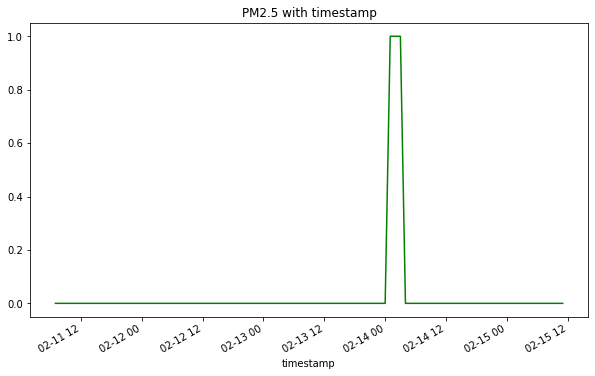

In [1054]:
newdata.iloc[900:1000, :]['anom'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

Text(0.5, 1.0, 'PM2.5 with timestamp')

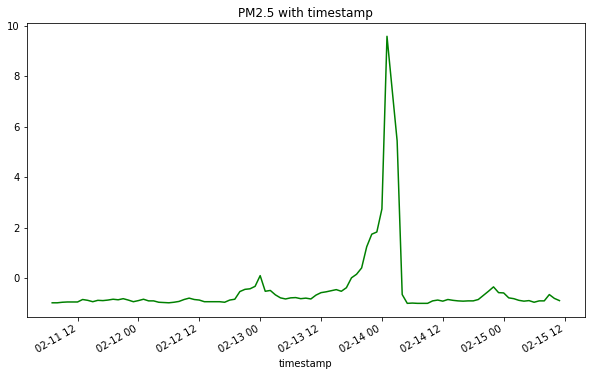

In [1055]:
newdata.iloc[900:1000, :]['pm2.5'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

In [1056]:
newdata.iloc[950:980, :]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,
2010-02-13 09:00:00,-0.788842,-1.299059,-1.593529,1.413211,-0.193489,-0.463078,-0.071056,-0.137407,0
2010-02-13 10:00:00,-0.821433,-1.368342,-1.429261,1.413211,-0.193489,-0.445140,-0.071056,-0.137407,0
2010-02-13 11:00:00,-0.669342,-1.368342,-1.264993,1.316130,-1.152708,-0.444939,-0.071056,-0.137407,0
2010-02-13 12:00:00,-0.571570,-1.437624,-1.018591,1.219050,-0.193489,-0.463078,-0.071056,-0.137407,0
2010-02-13 13:00:00,-0.538979,-1.506907,-0.936457,1.121969,-1.152708,-0.444939,-0.071056,-0.137407,0
2010-02-13 14:00:00,-0.495524,-1.506907,-0.772189,1.024889,-0.193489,-0.444939,-0.071056,-0.137407,0
2010-02-13 15:00:00,-0.452070,-1.506907,-0.772189,0.927808,-1.152708,-0.417932,-0.071056,-0.137407,0
2010-02-13 16:00:00,-0.517252,-1.506907,-0.772189,0.927808,-1.152708,-0.336912,-0.071056,-0.137407,0
2010-02-13 17:00:00,-0.376025,-1.506907,-0.854323,0.927808,-1.152708,-0.255893,-0.071056,-0.137407,0


In [1057]:
normal_mask = newdata['anom']==0
anomaly_mask = newdata['anom']==1
newdata.drop('anom',axis=1,inplace=True)
df_normal = newdata[normal_mask]
df_anomaly = newdata[anomaly_mask]

In [1058]:
df_normal.iloc[950:980, :]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-02-13 10:00:00,-0.821433,-1.368342,-1.429261,1.413211,-0.193489,-0.445140,-0.071056,-0.137407
2010-02-13 11:00:00,-0.669342,-1.368342,-1.264993,1.316130,-1.152708,-0.444939,-0.071056,-0.137407
2010-02-13 12:00:00,-0.571570,-1.437624,-1.018591,1.219050,-0.193489,-0.463078,-0.071056,-0.137407
2010-02-13 13:00:00,-0.538979,-1.506907,-0.936457,1.121969,-1.152708,-0.444939,-0.071056,-0.137407
2010-02-13 14:00:00,-0.495524,-1.506907,-0.772189,1.024889,-0.193489,-0.444939,-0.071056,-0.137407
2010-02-13 15:00:00,-0.452070,-1.506907,-0.772189,0.927808,-1.152708,-0.417932,-0.071056,-0.137407
2010-02-13 16:00:00,-0.517252,-1.506907,-0.772189,0.927808,-1.152708,-0.336912,-0.071056,-0.137407
2010-02-13 17:00:00,-0.376025,-1.506907,-0.854323,0.927808,-1.152708,-0.255893,-0.071056,-0.137407
2010-02-13 18:00:00,0.015066,-1.368342,-1.018591,0.927808,-1.152708,-0.174873,-0.071056,-0.137407


In [1059]:
X_normal = df_normal.values
X_anomaly = df_anomaly.values

In [1119]:
X_normal

array([[ 0.33011035, -1.2297765 , -1.34712702, ..., -0.44493877,
        -0.07105638, -0.13740677],
       [ 0.53651904, -1.160494  , -1.34712702, ..., -0.42700155,
        -0.07105638, -0.13740677],
       [ 0.65601881, -0.88336398, -1.42926109, ..., -0.40906433,
        -0.07105638, -0.13740677],
       ...,
       [-0.96265988, -1.64547154, -1.26499295, ...,  4.41040507,
        -0.07105638, -0.13740677],
       [-0.98438711, -1.64547154, -1.34712702, ...,  4.49142488,
        -0.07105638, -0.13740677],
       [-0.94093265, -1.57618903, -1.26499295, ...,  4.55450747,
        -0.07105638, -0.13740677]])

In [1061]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    X_normal, test_size=0.25, random_state=0)

In [1157]:
model = Sequential()
model.add(Dense(5, input_dim=X_normal.shape[1], activation='relu'))
model.add(Dense(4, activation='relu')) # size to compress to
model.add(Dense(5, activation='relu'))
model.add(Dense(X_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

Train on 31152 samples
Epoch 1/100
31152/31152 [==============================] - 3s 92us/sample - loss: 0.6319
Epoch 2/100
31152/31152 [==============================] - 2s 72us/sample - loss: 0.3971
Epoch 3/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.3123
Epoch 4/100
31152/31152 [==============================] - 2s 67us/sample - loss: 0.2440
Epoch 5/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.2215
Epoch 6/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.2114
Epoch 7/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.2042
Epoch 8/100
31152/31152 [==============================] - 2s 78us/sample - loss: 0.1989
Epoch 9/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.1919
Epoch 10/100
31152/31152 [==============================] - 2s 69us/sample - loss: 0.1832
Epoch 11/100
31152/31152 [==============================] - 2s 68us/sample - loss: 0.1

31152/31152 [==============================] - 2s 73us/sample - loss: 0.1478
Epoch 92/100
31152/31152 [==============================] - 2s 73us/sample - loss: 0.1476
Epoch 93/100
31152/31152 [==============================] - 2s 71us/sample - loss: 0.1476
Epoch 94/100
31152/31152 [==============================] - 2s 72us/sample - loss: 0.1477
Epoch 95/100
31152/31152 [==============================] - 2s 74us/sample - loss: 0.1476
Epoch 96/100
31152/31152 [==============================] - 2s 69us/sample - loss: 0.1478
Epoch 97/100
31152/31152 [==============================] - 2s 74us/sample - loss: 0.1474
Epoch 98/100
31152/31152 [==============================] - 2s 70us/sample - loss: 0.1477
Epoch 99/100
31152/31152 [==============================] - 2s 63us/sample - loss: 0.1476
Epoch 100/100
31152/31152 [==============================] - 2s 64us/sample - loss: 0.1476


In [1066]:
# input_dim=X_normal.shape[1]
# hiden_dim = 5
# # first_hidden_layer_dim = 7
# # last_hidden_layer_dim = 7
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(7, activation='elu', input_dim=X_normal.shape[1]), 
# #     tf.keras.layers.GaussianNoise(0.05),
#     tf.keras.layers.Dense(hiden_dim, activation='elu'),
#     tf.keras.layers.Dense(7, activation='elu')
# ])
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(x_normal_train,x_normal_train,verbose=1,epochs=40)

In [1159]:
pred1 = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_normal_test))
pred2 = model.predict(X_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred2,X_normal))
pred3 = model.predict(X_anomaly)
score3 = np.sqrt(metrics.mean_squared_error(pred3,X_anomaly))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anomaly Underway Score (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 0.3831630607705192
Insample Normal Score (RMSE): 0.38364745882545026
Anomaly Underway Score (RMSE): 1.1020954913218064


In [1085]:
X_anomaly.shape

(221, 8)

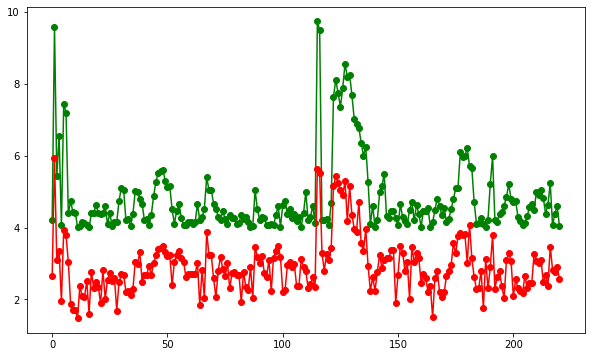

In [1160]:
x = range(221)
y1 = X_anomaly[:, 0]
y2 = pred3[:, 0]
plt.figure
plt.plot(x, y1, '-og');
plt.plot(x, y2, '-or')

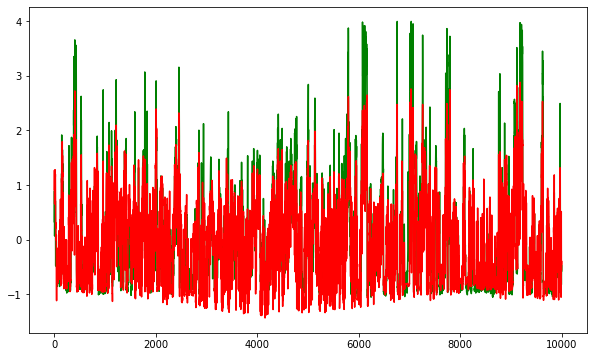

In [1161]:
x = range(10000)
y1 = X_normal[:10000, 0]
y2 = pred2[:10000, 0]
plt.figure
plt.plot(x, y1, '-g');
plt.plot(x, y2, '-r');

In [1098]:
X_normal[0]

array([ 0.33011035, -1.2297765 , -1.34712702,  0.34532536, -1.15270772,
       -0.44493877, -0.07105638, -0.13740677])

In [1099]:
pred2[0]

array([ 0.34292042, -0.8509086 , -0.9935832 ,  1.0303043 , -1.092319  ,
       -0.4189151 , -0.07980257, -0.14069712], dtype=float32)